In [9]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops
import random
import glob
import os
from sklearn.cluster import KMeans
from PIL import Image as im 

# Set seed for K-means clustering reproducibility
random.seed(10)

In [10]:
def remove_large_background(array,window_size,step_size,max_mean):
    '''
    Scans across an image and removes large pixel blobs i.e. blocks where almost all pixels are filled in.
    Parameters:
    array: input 2d array of pixels
    window_size: size of box used when calculating proportion of filled pixels.  Should be larger than desired cell width.
    step_size: movement distance between one window and the next
    max_mean: mean that pixels in a window must reach for them to be removed.
    '''
    clean_array=np.copy(array)
    for i in range(0,len(array)-window_size,step_size):
        for j in range(0,len(array[i])-window_size,step_size):    
            subset=array[i:i+window_size,j:j+window_size]
            if subset.mean()>max_mean:
                clean_array[max(i-step_size,0):min(i+window_size+step_size,len(array)-1),max(j-window_size,0):min(j+window_size+step_size,len(array[i]))]=0 #replace pixels of region passing max_mean threshold with 0
    return clean_array

def make_custom_grayscale(red_channel,blue_channel):
    '''
    Convert red and blue channels to a single grayscale array by taking the max at each coordinate.
    Parameters:
    red_channel: 2d np array of red pixel values
    blue_channel: 2d np array of blue pixel values
    '''
    custom_gray=[]
    for i,row in enumerate(red_channel):
        custom_gray.append([])
        for j,col in enumerate(row):
            if red_channel[i,j]>blue_channel[i,j]:
                custom_gray[-1].append(red_channel[i,j]*255)
            else:
                custom_gray[-1].append(blue_channel[i,j]*255)
    custom_gray=np.array(custom_gray).astype(np.uint8)
    return custom_gray

In [25]:
# K-means approach as a function
def Kmeans_process_image(image_path):
    # 1. Read image and convert to RGB
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Split into RGB channels for thresholding
    red_channel = image_rgb[:, :, 0]
    blue_channel = image_rgb[:, :, 2]
    
    # 2. Define thresholds for red and blue channels based on percentiles
        # try: r-92,b-95
    red_threshold = np.percentile(red_channel, 85)
    blue_threshold = np.percentile(blue_channel, 95)
    
        # Create binary masks for each color channel
            # CHANGED from red/blue_threshold
    _, red_mask = cv2.threshold(red_channel, red_threshold, 255, cv2.THRESH_BINARY)
    _, blue_mask = cv2.threshold(blue_channel, blue_threshold, 255, cv2.THRESH_BINARY)
        # Combine the red and blue masks
    combined_mask = cv2.bitwise_or(red_mask, blue_mask)
        # Apply the mask to isolate high-intensity pixels in the image
    thresholded_image = cv2.bitwise_and(image_rgb, image_rgb, mask=combined_mask)

    # 3. Perform K-means clustering
        # Flatten the masked pixels (ignore dark background)
    masked_pixels = thresholded_image[combined_mask > 0]
    pixels = masked_pixels.reshape((-1, 3)).astype(np.float32)
        # Define K-means criteria and number of clusters
    k = 4  # Number of clusters
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        # Perform K-means clustering--cv2
    # _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        # preform K-means clustering--scikit
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(pixels)
        # Convert centers to uint8 for display
    centers = np.uint8(kmeans.cluster_centers_)
        # Reconstruct segmented data using labels
    labels = kmeans.labels_
    segmented_data = centers[labels.flatten()]
        # Create an empty array to store the full-sized segmented image
    segmented_image = np.zeros_like(image_rgb)
        # Fill in only the high-intensity pixels in the original mask
    segmented_image[combined_mask > 0] = segmented_data

    # 4. Subset mask by keeping only the clusters corresponding to red and blue
        # Automate cluster characterization based on RBG values
            # instantiate cluster values
    bg_cluster = -1
    red_cluster = -1
    blue_cluster = -1
    lab_cluster = -1
        # instantiate list of color values outside loop
    max_g_val = -1
    max_r_val = -1
    max_b_val = -1
        # 4.1: Identify labels cluster
            # iterate over centers (RGB values)
    for idx, cntr in enumerate(centers):
        print(idx, cntr)
            # set green value
        g_val = cntr[1]
            # compare to max green value
        if g_val > max_g_val:
                # update max green value
            max_g_val = g_val
                # set max green value to background cluster
            lab_cluster = idx
        # identify red cluster
    for idx, cntr in enumerate(centers):
            # exclude cluster previously identified as bg
        if idx != lab_cluster:
            # set red value
            r_val = cntr[0]
            # compare to max red value
            if r_val > max_r_val:
                max_r_val = r_val
                red_cluster = idx
        # 4.3: Identify BLUE cluster
    for idx, cntr in enumerate(centers):
            # exclude clusters previously identified as bg & red
        if idx != lab_cluster and idx != red_cluster:
            # set red value
            b_val = cntr[2]
            # compare to max red value
            if b_val > max_b_val:
                max_b_val = b_val
                blue_cluster = idx
        # 4.2: Identify bg cluster
    for idx, cntr in enumerate(centers):
            # exclude cluster previously identified as bg
        if idx != lab_cluster and idx != red_cluster and idx != blue_cluster:
            bg_cluster = idx
    print("Background cluster is", bg_cluster)
    print("Labeled cluster is", lab_cluster)
    print("Red cluster is", red_cluster)
    print("Blue cluster is", blue_cluster)
        # Reshape labels to match combined_mask shape
    labels_reshaped = np.zeros(combined_mask.shape, dtype=int)
    labels_reshaped[combined_mask > 0] = labels.flatten()
        # Create a mask that includes only the red and blue clusters
    foreground_mask = np.isin(labels_reshaped, [red_cluster, blue_cluster])
    bg_mask = np.isin(labels_reshaped, [bg_cluster, lab_cluster])
        # Initialize the foreground image with black background
    foreground_final = np.zeros_like(image_rgb)
    bground_final = np.zeros_like(image_rgb)
        # Apply the mask to keep only the red and blue clusters
    foreground_final[foreground_mask] = image_rgb[foreground_mask]
    bground_final[bg_mask] = image_rgb[bg_mask]

    # 5. Perform Canny edge detection on the final foreground
        # foreground_final or custom_gray
    edges = cv2.Canny(foreground_final, 100, 200, apertureSize=3, L2gradient=False)

    # 6. Find contours and filter by area
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Set minimum & maximum cell area threshold
    min_area = 500
    max_area = 15000
    
    # Set aspect ratio thresholds (adjust based on cell shapes in your images)
    min_aspect_ratio = 1.0  # Minimum ratio for pencil-shaped cells
    max_aspect_ratio = 20.0  # Maximum ratio for pencil-shaped cells
    
    cell_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            # Calculate bounding rectangle and aspect ratio
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = max(w, h) / min(w, h)  # Ensure the ratio is always >= 1
            # print(w,h,aspect_ratio)
            # Filter by aspect ratio
            if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
                cell_contours.append(cnt)
    
        # Initialize metrics for counting and blue:red ratio
    total_cells = len(cell_contours)
    cell_ratios = []
        # Create a copy of the original image for cell-labeling
    labeled_image = foreground_final.copy()
        # Count all filtered edges (cells) & calculate blue:red ratio
    print(f"Total cells detected: {total_cells}")

    # 7. Calculate blue:red ratios within each cell
    for i, contour in enumerate(cell_contours):
        # Create a mask for each cell
        cell_mask = np.zeros(foreground_mask.shape, dtype=np.uint8)
        cv2.drawContours(cell_mask, [contour], -1, 255, -1)  # Fill contour to create mask
        # Extract pixels in red and blue channels for this cell
        red_values = red_channel[cell_mask == 255]
        blue_values = blue_channel[cell_mask == 255]
        # Calculate blue:red ratio for this cell
        red_sum = np.sum(red_values)
        blue_sum = np.sum(blue_values)
        blue_red_ratio = blue_sum / red_sum if red_sum > 0 else 0  # Avoid division by zero
        proportion_infected = blue_sum / (blue_sum + red_sum) if (blue_sum + red_sum) > 0 else 0
        cell_ratios.append({
            'Cell Number': i + 1,
            'Red Intensity Sum': red_sum,
            'Blue Intensity Sum': blue_sum,
            'Blue:Red Ratio': blue_red_ratio,
            'Proportion Infected': proportion_infected
        })
            # Label the detected cell on the image
        M = cv2.moments(contour)  # Get moments of the contour to calculate centroid
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])  # Centroid X
            cY = int(M["m01"] / M["m00"])  # Centroid Y
            cv2.putText(
                labeled_image, 
                str(i + 1),  # Label with cell number
                (cX, cY),  # Position at centroid
                cv2.FONT_HERSHEY_SIMPLEX, 
                3,  # Font size
                (255, 255, 255),  # White text
                2  # Thickness
            )

    # add edges to labeled image
    cv2.drawContours(labeled_image, cell_contours, -1, (0, 255, 0), 2)  # Green contours with thickness 2

    # 8. Convert ratios to DataFrame for easy viewing
    cell_ratios_df = pd.DataFrame(cell_ratios)
        # Calculate & report image overall blue:red ratio
    total_red = np.sum(red_channel[foreground_mask])
    total_blue = np.sum(blue_channel[foreground_mask])
    overall_blue_red_ratio = total_blue / total_red if total_red > 0 else 0
        # Display results
    print("\nIndividual Cell Blue:Red Ratios")
    # print(cell_ratios_df)
    print(f"\nTotal Cells: {total_cells}")
    print(f"Overall Blue:Red Ratio in Image: {overall_blue_red_ratio:.2f}")
    # Convert labeled_image (numpy array) to a Pillow image
    labeled_image_pil = im.fromarray(labeled_image)
 
        # Display the final cell edges
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(image_rgb)
    plt.title('Original RGB')
    plt.subplot(1, 4, 2)
    plt.imshow(bground_final, cmap='gray') #edges, bground_final
    plt.title('BG mask') # Canny Edge Detection
    plt.subplot(1, 4, 3)
    plt.imshow(labeled_image)
    plt.title('Foreground with Detected Cells')
    plt.subplot(1, 4, 4)
    plt.imshow(labeled_image_pil)
    plt.title('Returned Image')
    plt.show()
    # print(type(cell_ratios_df))
    # print(type(labeled_image))
    return cell_ratios_df, labeled_image_pil


0 [50  0 46]
1 [ 40   0 221]
2 [241 236 241]
3 [ 43   1 117]
Background cluster is 3
Labeled cluster is 2
Red cluster is 0
Blue cluster is 1
Total cells detected: 9

Individual Cell Blue:Red Ratios

Total Cells: 9
Overall Blue:Red Ratio in Image: 1.14


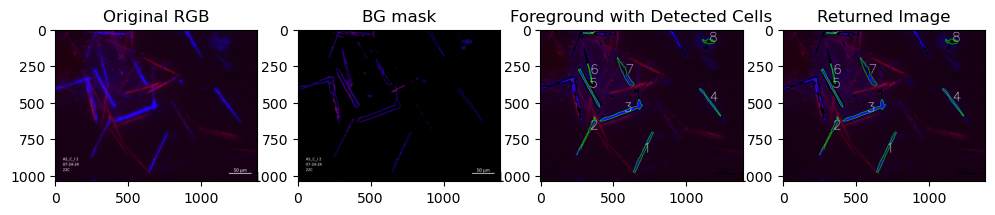

<class 'numpy.ndarray'>


(   Cell Number  Red Intensity Sum  Blue Intensity Sum  Blue:Red Ratio  \
 0            1             153348              666759        4.348012   
 1            2             102464              284632        2.777873   
 2            3             244794             1540521        6.293132   
 3            4              64603              489257        7.573286   
 4            5             182064              840615        4.617140   
 5            6              36344              191581        5.271324   
 6            7             178493              768912        4.307799   
 7            8              43770              185612        4.240621   
 8            9              34715              135587        3.905718   
 
    Proportion Infected  
 0             0.813015  
 1             0.735301  
 2             0.862885  
 3             0.883359  
 4             0.821973  
 5             0.840544  
 6             0.811598  
 7             0.809183  
 8             0.796156 

In [26]:
img_path = "../../images/ClumpyLate_AS_C_I_22_2_20240724.jpg"
Kmeans_process_image(img_path)

# # Convert labeled_image (numpy array) to a Pillow image and save as JPEG
# labeled_image_pil = im.fromarray(labeled_image)
# labeled_image_pil.save("labeled_output.jpg")


Processing THN_STARTER_1-20240716.jpg
0 [48  0 73]
1 [ 28   0 131]
2 [230 223 239]
3 [ 28   0 226]
Background cluster is 1
Labeled cluster is 2
Red cluster is 0
Blue cluster is 3
Total cells detected: 12

Individual Cell Blue:Red Ratios

Total Cells: 12
Overall Blue:Red Ratio in Image: 2.48


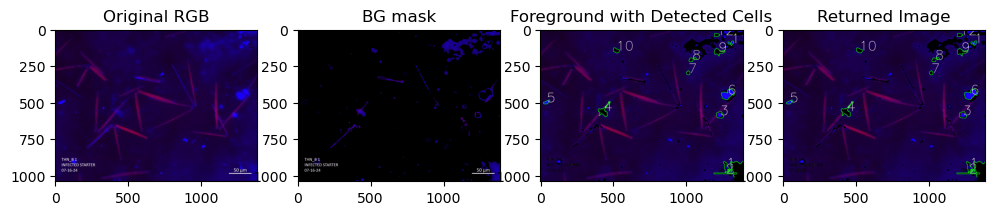

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_STARTER_1-20240716.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_STARTER_1-20240716_labeled.jpg

Processing THN_A_I_15_1-20240724.jpg
0 [50  0 70]
1 [ 46   0 120]
2 [230 222 235]
3 [ 50   0 215]
Background cluster is 1
Labeled cluster is 2
Red cluster is 0
Blue cluster is 3
Total cells detected: 9

Individual Cell Blue:Red Ratios

Total Cells: 9
Overall Blue:Red Ratio in Image: 1.78


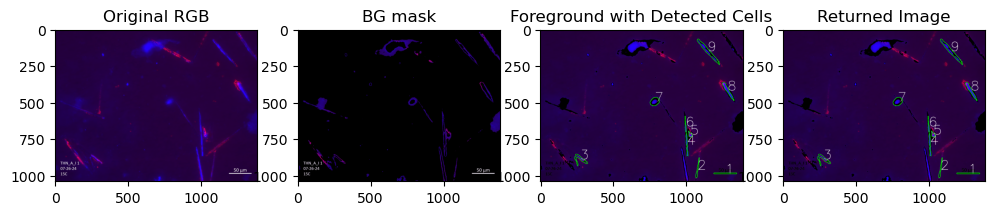

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_A_I_15_1-20240724.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_A_I_15_1-20240724_labeled.jpg

Processing AS_C_U_15_3-20240717.jpg
0 [33  0 37]
1 [14  0 86]
2 [234 229 237]
3 [ 13   0 204]
Background cluster is 1
Labeled cluster is 2
Red cluster is 0
Blue cluster is 3
Total cells detected: 2

Individual Cell Blue:Red Ratios

Total Cells: 2
Overall Blue:Red Ratio in Image: 2.38


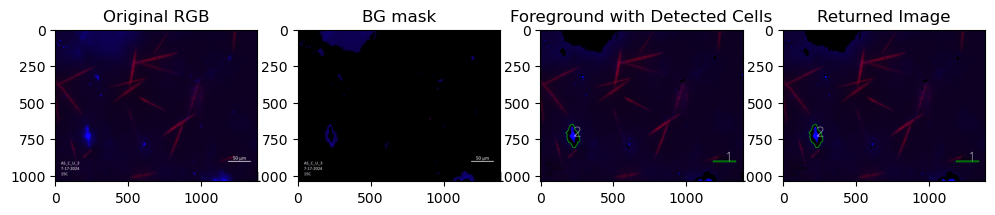

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_C_U_15_3-20240717.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_C_U_15_3-20240717_labeled.jpg

Processing AS_A_I_22_4-20240718.jpg
0 [39  0 31]
1 [ 29   0 100]
2 [ 34   0 216]
3 [230 223 230]
Background cluster is 1
Labeled cluster is 3
Red cluster is 0
Blue cluster is 2
Total cells detected: 5

Individual Cell Blue:Red Ratios

Total Cells: 5
Overall Blue:Red Ratio in Image: 1.22


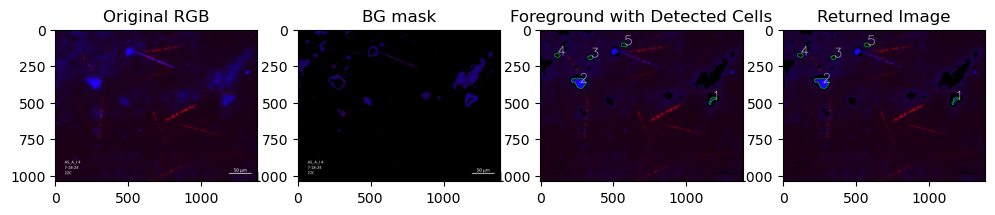

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_A_I_22_4-20240718.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_A_I_22_4-20240718_labeled.jpg

Processing AS_B_I_22_5-20240720.jpg
0 [36  0 43]
1 [ 28   0 205]
2 [240 235 241]
3 [125   3  48]
Background cluster is 0
Labeled cluster is 2
Red cluster is 3
Blue cluster is 1
Total cells detected: 8

Individual Cell Blue:Red Ratios

Total Cells: 8
Overall Blue:Red Ratio in Image: 0.93


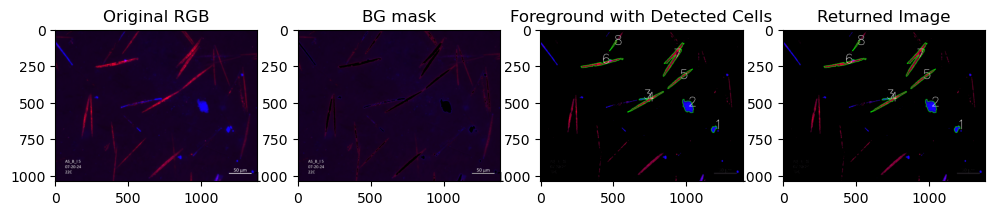

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_B_I_22_5-20240720.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_B_I_22_5-20240720_labeled.jpg

Processing AS_B_U_15_1-20240726.jpg
0 [29  0 53]
1 [236 232 239]
2 [ 17   0 197]
3 [127   3  60]
Background cluster is 0
Labeled cluster is 1
Red cluster is 3
Blue cluster is 2
Total cells detected: 6

Individual Cell Blue:Red Ratios

Total Cells: 6
Overall Blue:Red Ratio in Image: 1.93


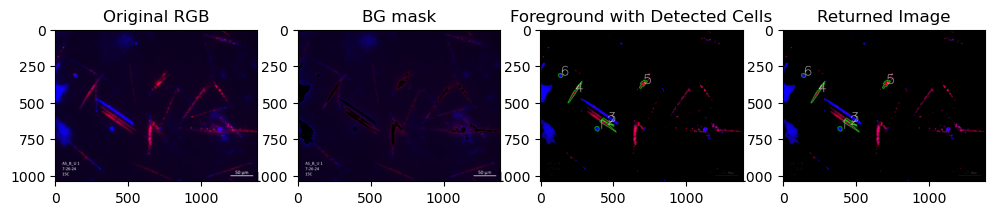

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_B_U_15_1-20240726.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_B_U_15_1-20240726_labeled.jpg

Processing AS_B_I_22_6-20240717.jpg
0 [36  0 40]
1 [243 237 244]
2 [162  14  49]
3 [ 31   0 207]
Background cluster is 0
Labeled cluster is 1
Red cluster is 2
Blue cluster is 3
Total cells detected: 4

Individual Cell Blue:Red Ratios

Total Cells: 4
Overall Blue:Red Ratio in Image: 1.18


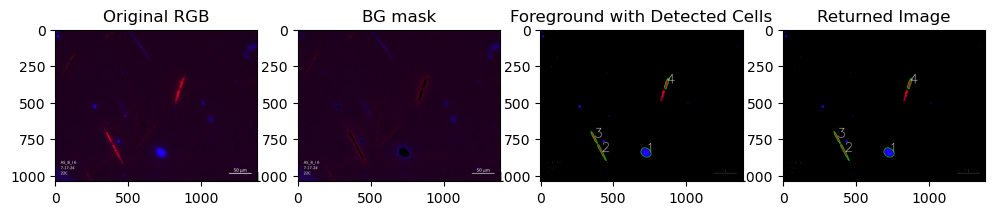

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_B_I_22_6-20240717.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_B_I_22_6-20240717_labeled.jpg

Processing THN_C_I_22_2-20240720.jpg
0 [15  0 44]
1 [239 235 243]
2 [ 30  15 164]
3 [52  1 41]
Background cluster is 0
Labeled cluster is 1
Red cluster is 3
Blue cluster is 2
Total cells detected: 7

Individual Cell Blue:Red Ratios

Total Cells: 7
Overall Blue:Red Ratio in Image: 1.21


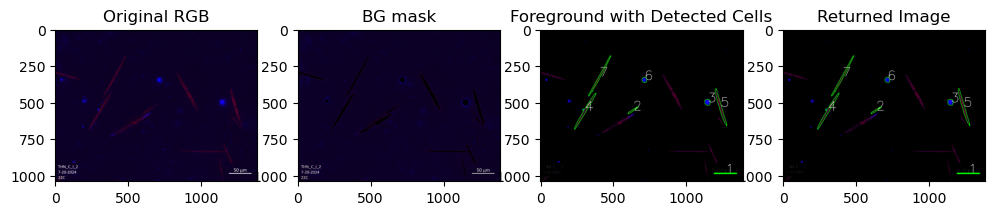

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_C_I_22_2-20240720.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_C_I_22_2-20240720_labeled.jpg

Processing THN_A_I_22_3-20240724.jpg
0 [31  0 33]
1 [242 236 242]
2 [ 40   9 142]
3 [72  1 30]
Background cluster is 0
Labeled cluster is 1
Red cluster is 3
Blue cluster is 2
Total cells detected: 7

Individual Cell Blue:Red Ratios

Total Cells: 7
Overall Blue:Red Ratio in Image: 0.89


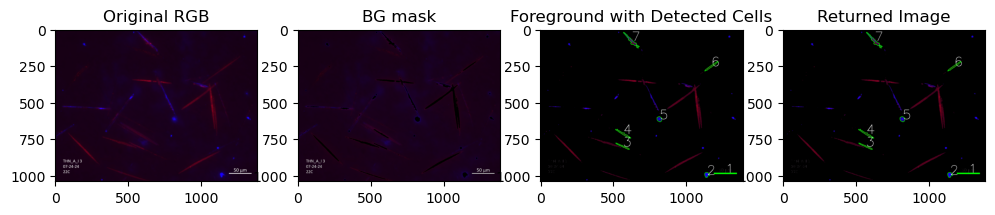

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_A_I_22_3-20240724.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_A_I_22_3-20240724_labeled.jpg

Processing AS_A_I_22_5-20240718.jpg
0 [38  0 29]
1 [242 236 242]
2 [31  0 78]
3 [ 36   5 133]
Background cluster is 2
Labeled cluster is 1
Red cluster is 0
Blue cluster is 3
Total cells detected: 11

Individual Cell Blue:Red Ratios

Total Cells: 11
Overall Blue:Red Ratio in Image: 1.01


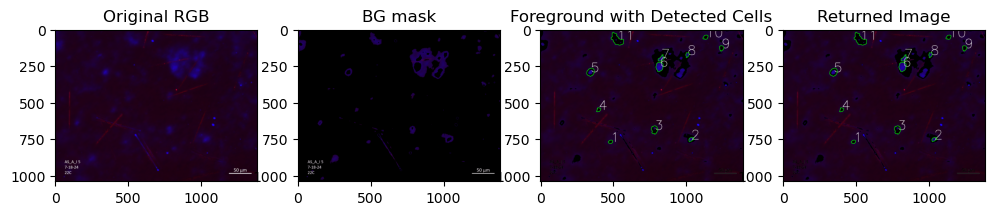

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_A_I_22_5-20240718.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_A_I_22_5-20240718_labeled.jpg

Processing THN_A_I_22_1-20240717.jpg
0 [57  0 25]
1 [241 234 239]
2 [43  0 65]
3 [115   2  34]
Background cluster is 0
Labeled cluster is 1
Red cluster is 3
Blue cluster is 2
Total cells detected: 10

Individual Cell Blue:Red Ratios

Total Cells: 10
Overall Blue:Red Ratio in Image: 0.79


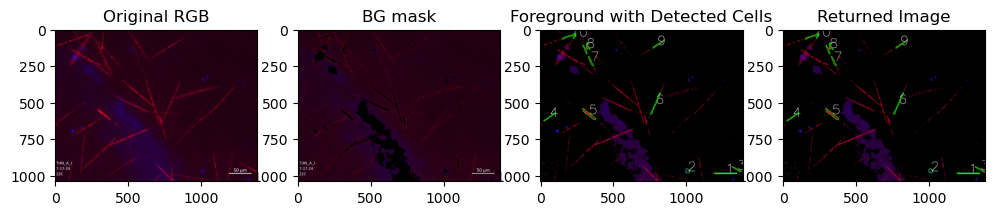

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_A_I_22_1-20240717.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_A_I_22_1-20240717_labeled.jpg

Processing AS_Starter_3-20240711.jpg
0 [19  0 26]
1 [  3   0 213]
2 [ 5  0 99]
3 [235 234 239]
Background cluster is 2
Labeled cluster is 3
Red cluster is 0
Blue cluster is 1
Total cells detected: 18

Individual Cell Blue:Red Ratios

Total Cells: 18
Overall Blue:Red Ratio in Image: 5.88


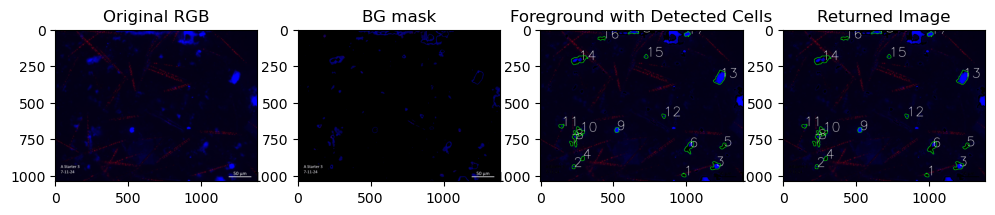

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_Starter_3-20240711.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_Starter_3-20240711_labeled.jpg

Processing AS_STARTER_2-20240716.jpg
0 [ 31   2 101]
1 [236 230 240]
2 [32  0 53]
3 [ 29   0 219]
Background cluster is 0
Labeled cluster is 1
Red cluster is 2
Blue cluster is 3
Total cells detected: 4

Individual Cell Blue:Red Ratios

Total Cells: 4
Overall Blue:Red Ratio in Image: 1.87


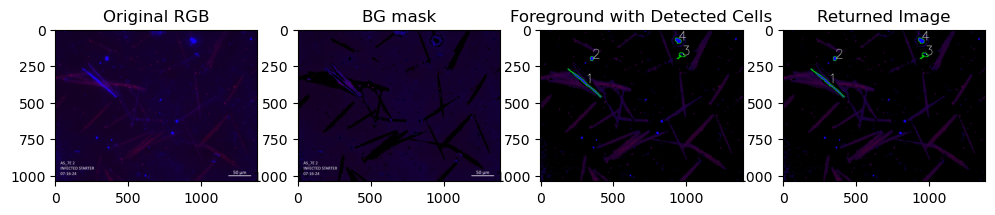

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_STARTER_2-20240716.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_STARTER_2-20240716_labeled.jpg

Processing AS_STARTER_5-20240716.jpg
0 [20  0 95]
1 [35  0 59]
2 [230 225 238]
3 [ 21   2 207]
Background cluster is 0
Labeled cluster is 2
Red cluster is 1
Blue cluster is 3
Total cells detected: 5

Individual Cell Blue:Red Ratios

Total Cells: 5
Overall Blue:Red Ratio in Image: 1.95


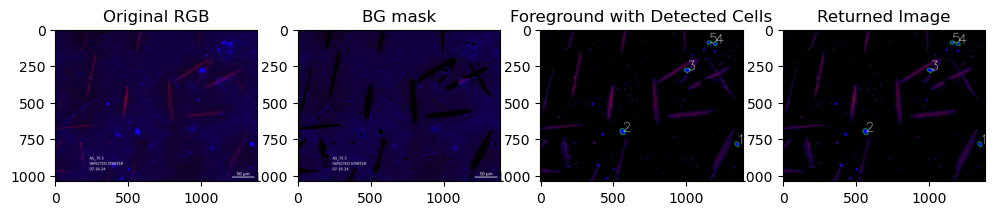

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_STARTER_5-20240716.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_STARTER_5-20240716_labeled.jpg

Processing AS_Starter_1-20240711.jpg
0 [21  0 30]
1 [  3   0 245]
2 [  5   0 183]
3 [236 236 244]
Background cluster is 2
Labeled cluster is 3
Red cluster is 0
Blue cluster is 1
Total cells detected: 12

Individual Cell Blue:Red Ratios

Total Cells: 12
Overall Blue:Red Ratio in Image: 7.29


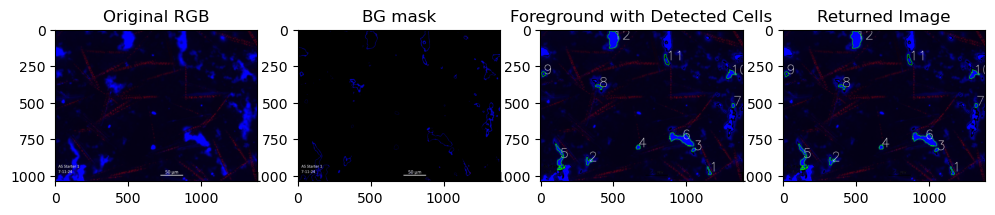

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_Starter_1-20240711.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_Starter_1-20240711_labeled.jpg

Processing THN_C_I_15_3-20240724.jpg
0 [ 30   0 185]
1 [239 235 241]
2 [30  0 39]
3 [101   3  49]
Background cluster is 2
Labeled cluster is 1
Red cluster is 3
Blue cluster is 0
Total cells detected: 7

Individual Cell Blue:Red Ratios

Total Cells: 7
Overall Blue:Red Ratio in Image: 1.85


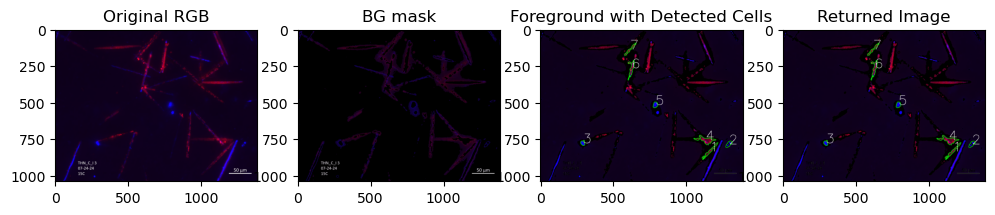

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_C_I_15_3-20240724.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_C_I_15_3-20240724_labeled.jpg

Processing AS_A_I_15_4-20240720.jpg
0 [38  0 57]
1 [ 29   0 235]
2 [240 235 243]
3 [ 40   1 158]
Background cluster is 0
Labeled cluster is 2
Red cluster is 3
Blue cluster is 1
Total cells detected: 1

Individual Cell Blue:Red Ratios

Total Cells: 1
Overall Blue:Red Ratio in Image: 4.92


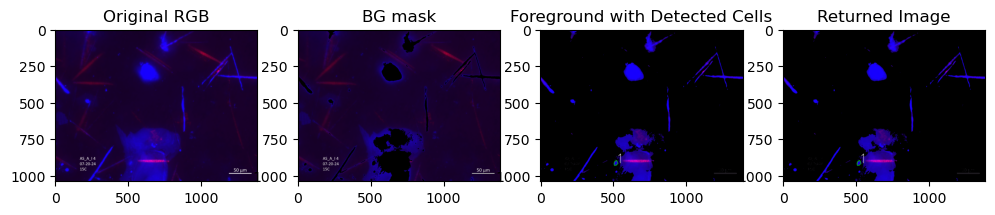

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_A_I_15_4-20240720.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_A_I_15_4-20240720_labeled.jpg

Processing THN_A_I_15_1-20240717.jpg
0 [224 223 234]
1 [15  0 57]
2 [76  1 55]
3 [  8   0 218]
Background cluster is 1
Labeled cluster is 0
Red cluster is 2
Blue cluster is 3
Total cells detected: 5

Individual Cell Blue:Red Ratios

Total Cells: 5
Overall Blue:Red Ratio in Image: 3.81


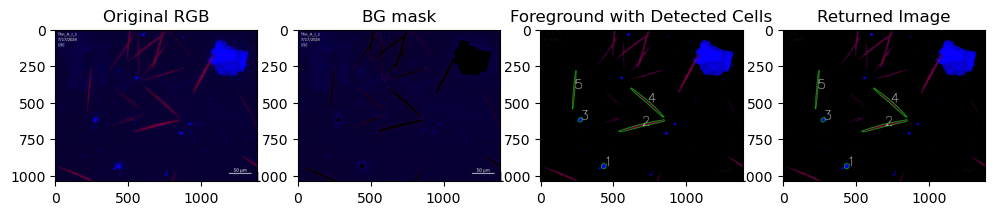

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_A_I_15_1-20240717.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_A_I_15_1-20240717_labeled.jpg

Processing AS_C_I_15_2-20240726.jpg
0 [30  0 49]
1 [ 20   0 126]
2 [227 222 231]
3 [ 21   0 215]
Background cluster is 1
Labeled cluster is 2
Red cluster is 0
Blue cluster is 3
Total cells detected: 6

Individual Cell Blue:Red Ratios

Total Cells: 6
Overall Blue:Red Ratio in Image: 2.75


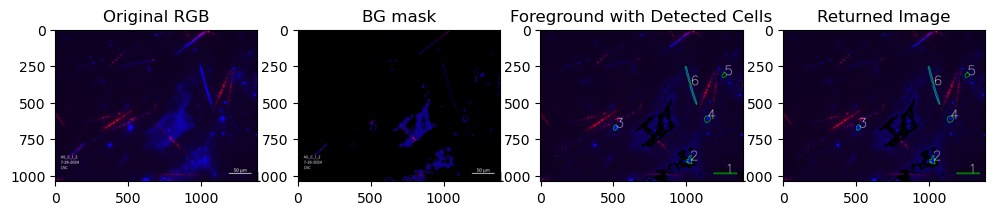

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_C_I_15_2-20240726.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_C_I_15_2-20240726_labeled.jpg

Processing THN_STARTER_4-20240716.jpg
0 [33  0 66]
1 [ 33   0 177]
2 [239 235 243]
3 [101   2  91]
Background cluster is 0
Labeled cluster is 2
Red cluster is 3
Blue cluster is 1
Total cells detected: 10

Individual Cell Blue:Red Ratios

Total Cells: 10
Overall Blue:Red Ratio in Image: 1.44


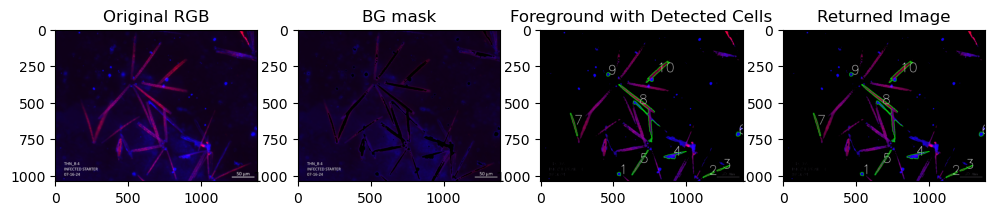

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_STARTER_4-20240716.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_STARTER_4-20240716_labeled.jpg

Processing AS_B_I_15_4-20240724.jpg
0 [31  0 40]
1 [ 49   0 233]
2 [29  0 94]
3 [239 235 243]
Background cluster is 0
Labeled cluster is 3
Red cluster is 1
Blue cluster is 2
Total cells detected: 8

Individual Cell Blue:Red Ratios

Total Cells: 8
Overall Blue:Red Ratio in Image: 3.62


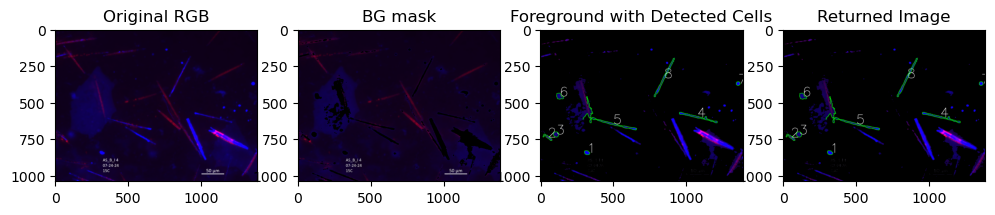

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_B_I_15_4-20240724.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_B_I_15_4-20240724_labeled.jpg

Processing THN_Starter_5-20240711.jpg
0 [17  0 28]
1 [ 6  1 74]
2 [230 229 234]
3 [  4   0 212]
Background cluster is 1
Labeled cluster is 2
Red cluster is 0
Blue cluster is 3
Total cells detected: 11

Individual Cell Blue:Red Ratios

Total Cells: 11
Overall Blue:Red Ratio in Image: 5.85


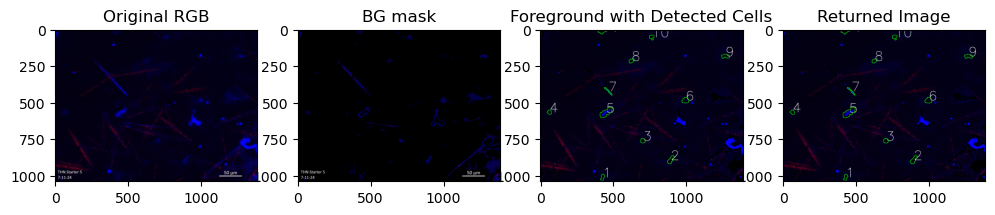

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_Starter_5-20240711.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_Starter_5-20240711_labeled.jpg

Processing THN_Starter_2-20240711.jpg
0 [ 4  0 68]
1 [223 222 227]
2 [10  0 26]
3 [  4   1 167]
Background cluster is 0
Labeled cluster is 1
Red cluster is 2
Blue cluster is 3
Total cells detected: 5

Individual Cell Blue:Red Ratios

Total Cells: 5
Overall Blue:Red Ratio in Image: 3.41


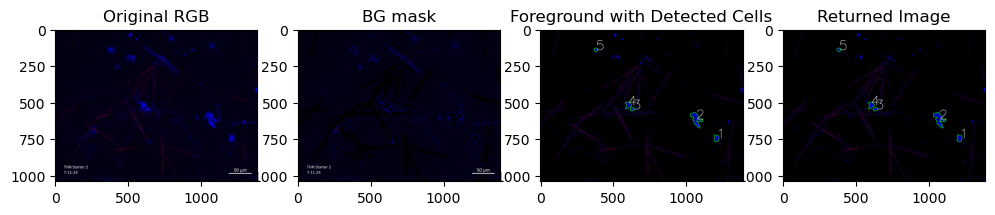

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_Starter_2-20240711.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_Starter_2-20240711_labeled.jpg

Processing AS_C_I_15_3-20240724.jpg
0 [231 123 181]
1 [47  0 54]
2 [ 36   0 228]
3 [ 33   0 117]
Background cluster is 3
Labeled cluster is 0
Red cluster is 1
Blue cluster is 2
Total cells detected: 7

Individual Cell Blue:Red Ratios

Total Cells: 7
Overall Blue:Red Ratio in Image: 1.58


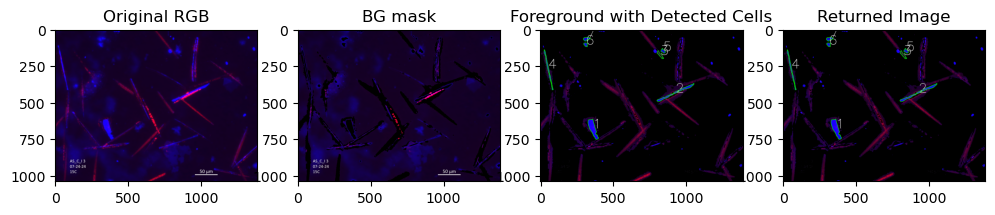

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/AS_C_I_15_3-20240724.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/AS_C_I_15_3-20240724_labeled.jpg

Processing THN_B_I_15_5-20240726.jpg
0 [36  0 52]
1 [ 42   0 190]
2 [242 237 244]
3 [157   2  89]
Background cluster is 0
Labeled cluster is 2
Red cluster is 3
Blue cluster is 1
Total cells detected: 10

Individual Cell Blue:Red Ratios

Total Cells: 10
Overall Blue:Red Ratio in Image: 1.81


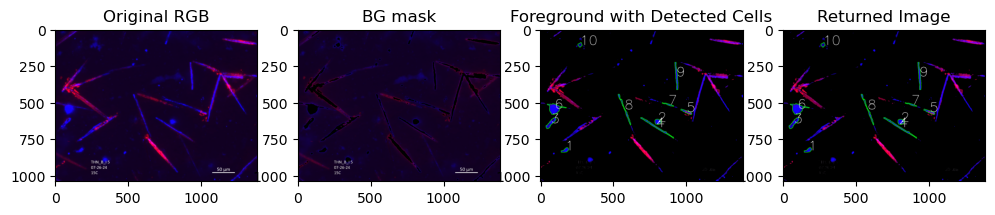

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_B_I_15_5-20240726.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_B_I_15_5-20240726_labeled.jpg

Processing THN_C_I_15_4-20240720.jpg
0 [53  0 46]
1 [143   1  48]
2 [240 234 243]
3 [ 37   0 198]
Background cluster is 0
Labeled cluster is 2
Red cluster is 1
Blue cluster is 3
Total cells detected: 17

Individual Cell Blue:Red Ratios

Total Cells: 17
Overall Blue:Red Ratio in Image: 0.63


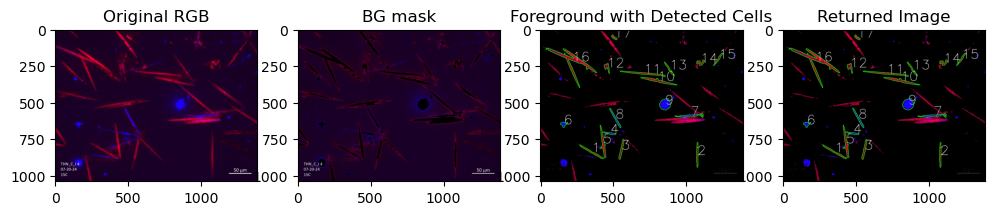

<class 'numpy.ndarray'>
Saved results to ../../figures/Kmeans_classification/data/THN_C_I_15_4-20240720.csv
Saved labeled image to ../../figures/Kmeans_classification/classified/THN_C_I_15_4-20240720_labeled.jpg


In [27]:
# Process all images in a folder
image_folder = "../../images/raw/"
image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))
csv_folder = "../../figures/Kmeans_classification/data/"
jpg_folder = "../../figures/Kmeans_classification/classified/"

for image_path in image_paths:
    print("")
    print(f"Processing {os.path.basename(image_path)}")
    df, image_output = Kmeans_process_image(image_path)
    # Generate basename
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    # Generate .csv output filename based on the input image name
    csv_output_path = os.path.join(csv_folder, f"{base_filename}.csv")
    image_output_path = os.path.join(jpg_folder, f"{base_filename}_labeled.jpg")

    # csv_output_filename = os.path.splitext(os.path.basename(image_path))[0] + ".csv"
    # csv_output_path = os.path.join(csv_folder, csv_output_filename)
    # Generate .jpg output filename based on the input image name
    # jpg_output_filename = os.path.splitext(os.path.basename(image_path))[0] + ".jpg"
    # jpg_output_path = os.path.join(jpg_folder, jpg_output_filename)
    
    # Save the dataframe to a CSV file
    df.to_csv(csv_output_path, index=False)
    # Save the image to a JPG file
    print(f"Saved results to {csv_output_path}")
    # Save the labeled image to a JPG file
    # cv2.imwrite(image_output_path, cv2.cvtColor(image_output, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving--OLD
    image_output.save(image_output_path)  # Convert back to BGR for saving--NEW
    print(f"Saved labeled image to {image_output_path}")


0 [ 51   0 150]
1 [57  0 69]
2 [243 234 244]
3 [120   2  72]
Background cluster is 1
Labeled cluster is 2
Red cluster is 3
Blue cluster is 0
Total cells detected: 9

Individual Cell Blue:Red Ratios

Total Cells: 9
Overall Blue:Red Ratio in Image: 1.67


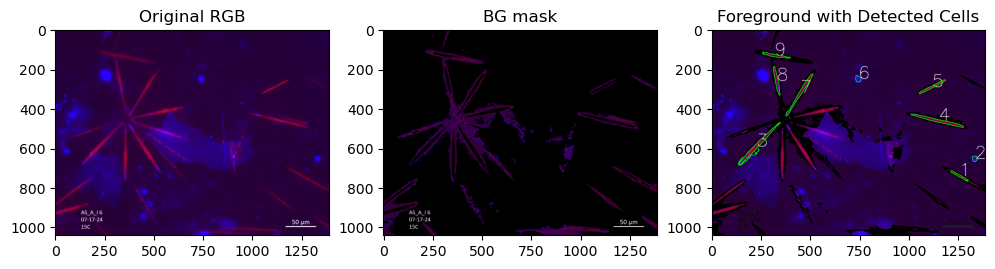

(   Cell Number  Red Intensity Sum  Blue Intensity Sum  Blue:Red Ratio  \
 0            1              95017               51386        0.540808   
 1            2              23231              146917        6.324179   
 2            3             524087              406832        0.776268   
 3            4             417040              246090        0.590087   
 4            5             196079               87974        0.448666   
 5            6              29244              178980        6.120230   
 6            7             334487              234140        0.699997   
 7            8             208639              179183        0.858818   
 8            9             138846               87218        0.628164   
 
    Proportion Infected  
 0             0.350990  
 1             0.863466  
 2             0.437022  
 3             0.371104  
 4             0.309710  
 5             0.859555  
 6             0.411764  
 7             0.462024  
 8             0.385811 

In [60]:
# set image path
# image_path = "../images/manual_classification/raw/AS_A_I_15_4-20240720.jpg"  # WD path
# image_path = "../images/raw/AS_A_I_15_4-20240720.jpg"  # WD path
image_path = "../images/GoodEarlySilica_AS_A_I_15_6_20240717.jpg"  # WD path

# call K-means function
# for image_path in image_paths:
Kmeans_process_image(image_path)

In [14]:
# check blue"red ratios for infection populations
# cell_ratios_df['Blue:Red Ratio'].hist()